In [1]:
import mmf_setup;res = mmf_setup.nbinit()

<IPython.core.display.Javascript object>

# Wigner-Ville Distribution

The Wigner-Ville quasiprobability distribution is a form of frequency analysis:

\begin{align}
  W(t, \omega) &= \int_{-\infty}^{\infty} 
    f(t+\tfrac{\tau}{2}) f^*(t-\tfrac{\tau}{2}) e^{-\I t \omega}\d{\tau}
    = 2\int_{-\infty}^{\infty} 
    f(t+\tau) f^*(t-\tau) e^{-2\I t \omega}\d{\tau}.
\end{align}

For quantum mechanics, one can write this as follows (Note: we use the wavevector $k = p/\hbar$ here to avoid extra factors of $\hbar$ that are not used in the code.)

\begin{align}
  P(x, k) &= 2\int_{-\infty}^{\infty} \psi(x+y)\psi^*(x-y) e^{-2\I ky}\d{y} 
\end{align}

Note that Wigner-Ville quasiprobability distribution satisfies the following properies:

* $P(x,k)$ is real:

  $$
    P(x, k) = P^*(x,k).
  $$
  
* Let $\op{R} = \ket{\psi}\bra{\psi}$ be the density operator:

  $$
    P(x, k) = \int\braket{k|x+y}\braket{x+y|\op{R}|x-y}\braket{x-y|k}\frac{\d{y}}{\pi}.
  $$

* Integrating over $x$ or $k$ gives the probability density in the complementary space:

  $$
    \braket{x|\op{R}|x} = \int_{-\infty}^{\infty}P(x, k) \frac{\d{k}}{2\pi} 
    = \abs{\psi(x)}^2\\
    \braket{k|\op{R}|k} = \int_{-\infty}^{\infty}P(x, k) \;\d{x}
    = \abs{\psi(k)}^2\\
    \Tr\op{R} = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}P(x, k)\;\d{x}\frac{\d{k}}{2\pi}
  $$


Note: there are some slightly different normalization conventions:

* [Wikipedia](https://en.wikipedia.org/wiki/Wigner_quasiprobability_distribution) uses the following because they do not include the factor of $2\pi$ with $\d{k}/(2\pi)$:
  
  $$
    P(x, k) = \frac{1}{\hbar\pi} \int_{-\infty}^{\infty} 
    \psi^*(x+y)\psi(x-y) e^{2\I ky/\hbar}\d{y}.
  $$

# Computation

The discrete version of the Wigner-Ville ditribution (DWVD) is

$$
  P(x_n, k_l) = 2\sum_{m=0}^{N-1}\psi_{n+m}\psi^*_{n-m}e^{-4\pi\I ml/N}.
$$

To compute this, we use the FFT noting the extra factor of $2$ in the frequency:

$$
  P(x_n, k_{l/2}) = \texttt{FFT}(\psi_{n+m}\psi^*_{n-m}).
$$

where the FFT acts on $m$ and  satisfies:

$$
  \texttt{FFT}(f) = \sum_{n=0}^{N-1} f_n e^{-2\pi \I m n/N}, \qquad
  \texttt{IFFT}(f) = \frac{1}{N}\sum_{n=0}^{N-1} f_n e^{2\pi \I m n/N}, \qquad
  \tilde{f}(\omega) = \frac{T}{N}\texttt{FFT}(f) 
  \equiv \int_{0}^{T} f(t) e^{-\I \omega t}\d{t}.
$$

One problem with this simple form of DWVD is that it introduces aliasing artifacts.  For example:

$$
  P(x_n+L/2, k_{l/2}) = 2\sum_m\psi_{n+N/2+m}\psi^*_{n+N/2-m}e^{-2\pi\I m l/N}
  = 2\sum_m\psi_{n+m}\psi^*_{n+N-m}e^{-2\pi\I (m-N/2)l/N}
  = e^{\pi\I l}P(x_n, k_{l/2}).
$$

Thus, features at position $x$ will have an oscillating alias at position $x+L/2$.  This can be seen in the Gaussian example below.

The only additional complication is that we must ensure that the sampled function $f(t+\tau)$ is appropriately defined outside of it's original range.  We do this by wrapping the indices modulo the length of the array.

# 1D Examples

In [2]:
%pylab inline --no-import-all
from __future__ import division
import numpy as np

from mmfutils.plot import imcontourf
from mmfutils.math import wigner

N = 128
L = 10.0
dx = L/N
x = np.arange(N)*dx - L/2
k = 2*np.pi * np.fft.fftshift(np.fft.fftfreq(N, dx))

Populating the interactive namespace from numpy and matplotlib


$$
  \psi(x) = e^{\I k_m x}, \qquad
  P(x, k_n) = 2L \delta_{mn}, \qquad
  \psi(x + L) = \psi(L), \qquad
  k_n = \frac{2\pi n}{L}.
$$

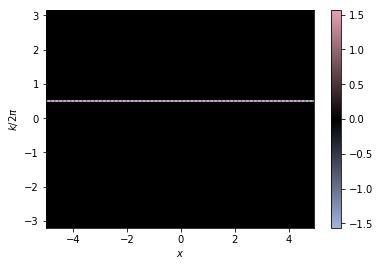

In [3]:
m = 5
w = 2*np.pi*m/L
psi = np.exp(1j*w*x)
ws, P = wigner.wigner_ville(psi, dt=dx, skip=1, pad=False)
P_exact = np.zeros_like(P)
P_exact[:, N//2 + m] = 2*L

#assert np.allclose(P, P_exact)
imcontourf(x, ws/(2*np.pi), P, interpolation='none', diverging=True)
plt.axhline(w/(2*np.pi), ls=':')
plt.xlabel('$x$');plt.ylabel(r'$k/2\pi$')
plt.colorbar()

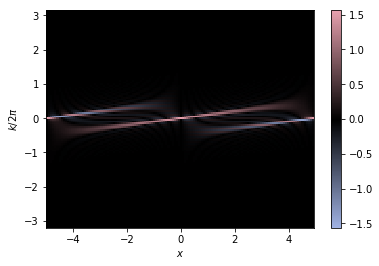

In [4]:
m = 1
w = 2*np.pi*m/L
psi = np.exp(1j*w*x**2/2)
ws, P = wigner.wigner_ville(psi, dt=dx, skip=1, pad=False)
P_exact = np.zeros_like(P)
P_exact[:, N//2 + m] = 2*L

#assert np.allclose(P, P_exact)
imcontourf(x, ws/(2*np.pi), P, interpolation='none', diverging=True)
plt.xlabel('$x$');plt.ylabel(r'$k/2\pi$')
plt.colorbar()

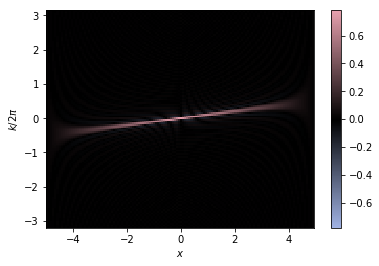

In [5]:
m = 1
w = 2*np.pi*m/L
psi = np.exp(1j*w*x**2/2)
ws, P = wigner.wigner_ville(psi, dt=dx, skip=1, pad=True)
P_exact = np.zeros_like(P)
P_exact[:, N//2 + m] = 2*L

#assert np.allclose(P, P_exact)
imcontourf(x, ws/(2*np.pi), P, interpolation='none', diverging=True)
plt.xlabel('$x$');plt.ylabel(r'$k/2\pi$')
plt.colorbar()

/data/apps/anaconda/envs/_test2/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


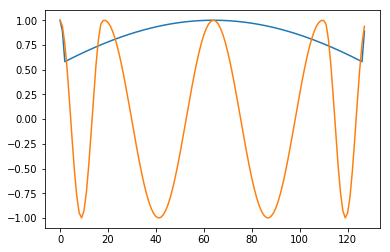

In [6]:
i = np.array([2, 18])[None, :]
j = np.arange(N)[:, None]
i_ = (i+j) % N
j_ = (i-j) % N
plt.plot(psi[i_]*psi.conj()[j_])

\begin{align}
  \psi(x) &= e^{-(x/r_0)^2/2}, &
  P(x, k) &= 2r_0\sqrt{\pi} e^{-(kr_0)^2 -(x/r_0)^2}
\end{align}

(-0.05, 0.05)

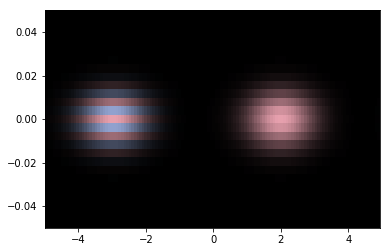

In [7]:
x0 = 2
dx = L/N
dk = 2*np.pi / L
r0 = 1
psi = np.exp(-((x-x0)/r0)**2/2)
ws, P = wigner.wigner_ville(psi, skip=1, pad=False)
P_exact = 2*np.sqrt(np.pi)*r0*np.exp(-(k[None, :]*r0)**2-((x[:, None]-x0)/r0)**2)
imcontourf(x, ws/(2*np.pi), P, interpolation='none', diverging=True)
plt.ylim(-0.05,0.05)

Here is the standard DWVD:

$$
  P(x_n, \tfrac{k}{2}) = 2\sum_{m=0}^{N} \psi_{n+m}\psi^*_{n-m}e^{-2\I k x_m}
$$

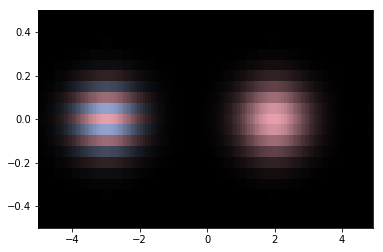

In [8]:
from numpy.fft import fft, ifft
n = np.arange(N)[:, None]
m = np.arange(N)[None, :]
i_ = (n + m) % N
j_ = (n - m) % N
Psi = psi[i_]*psi[j_].conj()
P = 2*fft(Psi, axis=-1) * dx
P = np.fft.fftshift(P, axes=-1)
assert np.allclose(P.imag, 0)
P = P.real
k = np.fft.fftshift(np.pi * np.fft.fftfreq(N, dx))
imcontourf(x, k/(2*np.pi), P, interpolation='none', diverging=True)
plt.ylim(-0.5,0.5);

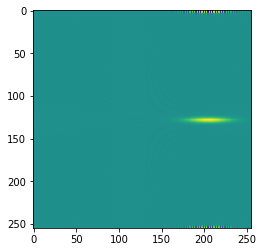

In [9]:
X = fft(np.hstack([psi, 0*psi]))

k = np.arange(-N, N-1)[:, None]
m = np.arange(2*N)[None, :]
i_ = (k + m) % (2*N)
j_ = (k - m) % (2*N)
Psi = X[i_]*X[j_].conj()

P = np.fft.fftshift(fft(Psi, axis=-1) * dx, axes=-1)
assert np.allclose(P.imag, 0)
plt.imshow(P.real)